## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2021.

# Assignment 2 - Task 2: Regularizations

In this task, you are going to experiment with two popular regularization methods. 

**Batch normalization:** Batch normalization makes it possible to train a deep network. When a network becomes deeper, the distribution of hidden neurons' values will also shift greatly, and that is one reason that makes it difficult to train a deep neural network. Machine learning taught us that normalization is a good preprocessing method to deal with such a problem. Therefore, batch normalization deploys a similar idea in the neural network by re-normalizing the hidden values of each layer before transfering values to the next layer.

**Dropout:** In the last assignment, you trained a shallow network and everything looked fine. However, when the network becomes larger and deeper, it will also become harder to train. The first potential problem is over-fitting, that is, the network overreacts to noise or random errors of the training data while failing to detect the underlying distribution pattern. It is more likely to occur when the model becomes complex and contains more trainable parameters. Dropout is a well-known method that can eliminate such effects. The core idea behind it is quite simple: rather than updating all trainable parameters each time, it randomly selects a subset of parameters to update and keeps other parameters unaltered.

* References
    * https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
    * https://arxiv.org/pdf/1502.03167.pdf
    * https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    * https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# Load the raw Fashion-MNIST data.
train, val = fashion_mnist.load_data()

X_train_raw, y_train = train
X_val_raw, y_val = val

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_val = X_val_raw.reshape((X_val_raw.shape[0], X_val_raw.shape[1]**2))

#Index from the 10000th image of the dataset
# X_val = X_train[10000:10500,:]
# y_val = y_train[10000:10500]
# X_train = X_train[10500:12500,:]
# y_train = y_train[10500:12500]

mean_image = np.mean(X_train, axis=0).astype(np.float32)
X_train = X_train.astype(np.float32) - mean_image
X_val = X_val.astype(np.float32) - mean_image

# We've vectorized the data for you. That is, we flatten the 32×32×3 images into 1×3072 Numpy arrays.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

Training data shape:  (60000, 784)
Training labels shape:  (60000,)
Validation data shape:  (10000, 784)
Validation labels shape:  (10000,)


## Part 1: Batch Normalization

### Implement batch normalization foward function

<span style="color:red"><strong>TODO:</strong></span> Edit functions **bn_forward** in **./utils/reg_funcs.py**. <br> If the code is running correctly, **mean of a2_bn for train will be very close to 0 and variance of a2_bn will be close to 1.**

In [3]:
####################################################
# Checking/verification code. Don't change it.     #
####################################################

from utils.reg_funcs import bn_forward
from utils.reg_funcs import bn_backward

np.random.seed(1338)
N, D, H1, H2 = 300, 20, 8, 3
x_in = np.random.randn(N, D)
w1 = np.random.randn(D,H1)
w2 = np.random.randn(H1,H2)
a2 = np.maximum(x_in.dot(w1),0).dot(w2)

# Before batch normalization
print("mean of a2: ", np.mean(a2, axis=0))
print("var of a2: ", np.var(a2, axis=0))

# Test "train mode" of forward function
# After batch normalization, the mean should be close to zero and var should be close to one. 
bn_config = {"epsilon":1e-5, "decay":0.9}
gamma = np.ones(H2)
beta = np.zeros(H2)
a2_bn, _ = bn_forward(a2, gamma, beta, bn_config, "train")
print("(train) mean of a2_bn: ", np.mean(a2_bn, axis=0))
print("(train) var of a2_bn: ", np.var(a2_bn, axis=0))

mean of a2:  [-3.71855056  3.21810258 -2.44388986]
var of a2:  [45.32564755 70.17112882 32.35120115]
(train) mean of a2_bn:  [-1.93178806e-16 -1.84297022e-16 -1.12132525e-16]
(train) var of a2_bn:  [0.99999978 0.99999986 0.99999969]


<span style="color:red"><strong>TODO:</strong></span> Test "moving average" and "test mode" of the bn_forward function. <br> We expect that the test mean & variance of a2 to be fairly close to the real values and the test mean & variance of a2_bn to be close to 0 and 1 respectively.

In [4]:
#######################################
# Checking code. Don't change it.     #
#######################################

# Test "moving average" and "test mode" of forward function
# Then you are going to run the forward function under "training mode" for several times, 
# and the moving mean and moving var will be close to the real mean and var of the input data.
# Next, run the forward function under "test" mode and you will see that the mean and var of its 
# output will be also close to gamma, beta that you have set before.

bn_config = {"epsilon":1e-5, "decay":0.9}
gamma = np.ones(H2)
beta = np.zeros(H2)

# collect_data: for calculating real mean and var of a2 later.
collect_data = a2
for _ in range(100):
    x_in = np.random.randn(N, D)
    a2 = np.maximum(x_in.dot(w1),0).dot(w2)
    collect_data = np.concatenate((collect_data, a2), axis=0)
    bn_forward(a2, gamma, beta, bn_config, "train")

# compare moving_mean and moving_var with real mean and var.
# You should see that they are close to each other.
print("real mean of data: ", np.mean(collect_data, axis=0))
print("real var of data: ", np.var(collect_data, axis=0))
print("moving mean of data: ", bn_config["moving_mean"])
print("moving var of data: ", bn_config["moving_var"])

# "test mode" of forward function
# After bn_forward, the mean and var of output should be kind of close to gamma and beta.
x_in = np.random.randn(N, D)
a2 = np.maximum(x_in.dot(w1),0).dot(w2)
print("*"*80)
print("(test) mean of a2: ", np.mean(a2, axis=0))
print("(test) var of a2: ", np.var(a2, axis=0))
a2_bn, _ = bn_forward(a2, gamma, beta, bn_config, "test")
print("(test) mean of a2_bn: ", np.mean(a2_bn, axis=0))
print("(test) var of a2_bn: ", np.var(a2_bn, axis=0))

real mean of data:  [-4.66597413  3.54558219 -2.76245923]
real var of data:  [52.21537611 68.48830775 34.90757554]
moving mean of data:  [-4.63615489  3.52523532 -2.76508416]
moving var of data:  [51.29127262 69.07311671 34.80902842]
********************************************************************************
(test) mean of a2:  [-4.91240989  4.48112074 -3.35659034]
(test) var of a2:  [58.07744964 66.79717707 36.85179509]
(test) mean of a2_bn:  [-0.03857344  0.11501415 -0.10025667]
(test) var of a2_bn:  [1.13230644 0.96705014 1.05868466]


<span style="color:red"><strong>TODO:</strong></span> Use TensorFlow 2 functions to verify the correctness of the backward function. You should use functions from TensorFlow 2 to get the gradients. 
<br>**Hint: use tf.GradientTape()**

In [19]:
# After verifying the forward function and save the bn_config.
x_in = np.random.randn(N, D)
a2 = np.maximum(x_in.dot(w1),0).dot(w2)
da2_bn = np.ones_like(a2)
# Test backward function with tensorflow
# You will use bn_config = {"eps":1e-5, "decay":0.9, "moving_mean":moving_mean, "moving_var":moving_var}
gamma = np.ones(H2)
beta = np.zeros(H2)
a2_bn, cache = bn_forward(a2, gamma, beta, bn_config, "test")
da2, dgamma, dbeta = bn_backward(da2_bn, cache)

###################################################
# TODO: verify the backward code. You should use  #
# the parameters in bn_config and other variables #
# above.                                          #
###################################################

a2_tf = tf.Variable(a2, name='a2')
gamma_tf = tf.Variable(gamma, name='gamma')
beta_tf = tf.Variable(beta, name='beta')

eps = bn_config['epsilon']
moving_mean = bn_config['moving_mean']
moving_var = bn_config['moving_var']

with tf.GradientTape() as tape:
    tape.watch([a2_tf, beta_tf, gamma_tf])
    a2_bn_tf = gamma_tf * (a2_tf - moving_mean) / np.sqrt(moving_var + eps) + beta_tf

da2_tf, dgamma_tf, dbeta_tf = tape.gradient(a2_bn_tf, (a2_tf, gamma_tf, beta_tf))

a2_bn_check = a2_bn_tf.numpy()
da2_check, dgamma_check, dbeta_check = da2_tf.numpy(), dgamma_tf.numpy(),dbeta_tf.numpy()
###################################################
# ENDTODO #
###################################################

# Make comparison
print("Is a2_bn correct? {}".format(np.allclose(a2_bn, a2_bn_check)))
print("Is da2 correct? {}".format(np.allclose(da2, da2_check)))
print("Is dgamma correct? {}".format(np.allclose(dgamma, dgamma_check)))
print("Is dbeta correct? {}".format(np.allclose(dbeta, dbeta_check)))

Is a2_bn correct? True
Is da2 correct? True
Is dgamma correct? True
Is dbeta correct? True


In [20]:
print(dgamma_tf)

tf.Tensor([-6.78120933 24.66936822 -3.93623082], shape=(3,), dtype=float64)


### Batch Normalization Experiments with MLP

<span style="color:red"><strong>TODO:</strong></span>

1. Add batch normalization into MLP. Please understand **loss**, **predict** functions of the class **MLP** in **./utils/neuralnets/mlp.py**

2. First create a shallow MLP like two-layer network like [100,10]. Train it without and with batch normalization. Plot the loss, training accuracy, and validation accuracy curves.

3. Then, create a 5-layer MLP network like [100,50,50,50,10] and train the network with and without batch normalization. Plot the loss, training accuracy, and validation accuracy curves.

4. Make a comparison and describe what you have found in this experiment.

**Experiment on shallow MLP** 

In [21]:
from utils.neuralnets.mlp import MLP 
from utils.optimizers import AdamOptim

In [28]:
# Build a two-layer network without batch normalization.
# Here is a demo.
use_bn = False
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100], num_classes=10, 
            weight_scale=1e-3, l2_reg=0.0, use_bn=use_bn)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_shallow_no_bn = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=15, batch_size=100, learning_rate=1e-3, learning_decay=0.95, 
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.85, new learning rate = 0.00095
epoch 2: valid acc = 0.8597, new learning rate = 0.0009025
epoch 3: valid acc = 0.8705, new learning rate = 0.000857375
epoch 4: valid acc = 0.8715, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.8732, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.8775, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.8794, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.8804, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.8809, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.8818, new learning rate = 0.0005987369392383785
epoch 11: valid acc = 0.8823, new learning rate = 0.0005688000922764595
epoch 12: valid acc = 0.8841, new learning rate = 0.0005403600876626365
epoch 13: valid acc = 0.8803, new learning rate = 0.0005133420832795047
epoch 14: valid acc = 0.8828, new learning rate = 0.00048767497911552944
epo

In [29]:
# Build a two-layer network with batch normalization. Remember to "use_bn".
use_bn = True
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100], num_classes=10, 
            weight_scale=1e-3, l2_reg=0.0, use_bn=use_bn)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_shallow_bn = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=15, batch_size=100, learning_rate=1e-3, learning_decay=0.95, 
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.7907, new learning rate = 0.00095
epoch 2: valid acc = 0.8142, new learning rate = 0.0009025
epoch 3: valid acc = 0.8206, new learning rate = 0.000857375
epoch 4: valid acc = 0.8299, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.8351, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.8376, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.8394, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.8422, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.8443, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.8462, new learning rate = 0.0005987369392383785
epoch 11: valid acc = 0.8484, new learning rate = 0.0005688000922764595
epoch 12: valid acc = 0.8498, new learning rate = 0.0005403600876626365
epoch 13: valid acc = 0.851, new learning rate = 0.0005133420832795047
epoch 14: valid acc = 0.8525, new learning rate = 0.00048767497911552944
ep

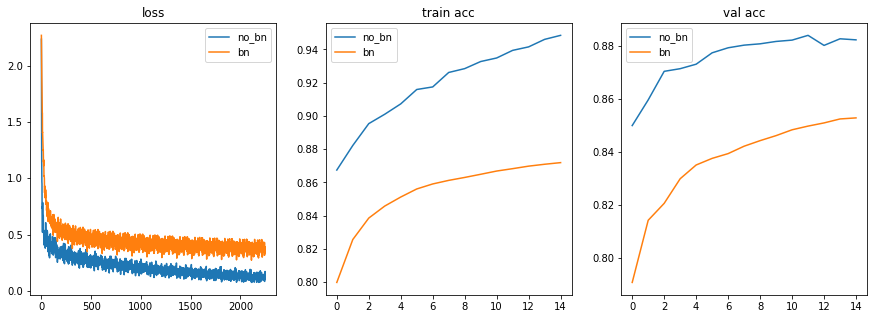

In [30]:
# Plot bn and no_bn results together in three plots and make a comparison. 
title_name = ["loss", "train acc", "val acc"]
_, axarr = plt.subplots(1,3, figsize=(15,5))
for i in range(3):
    axarr[i].plot(hist_shallow_no_bn[i], label="no_bn")
    axarr[i].plot(hist_shallow_bn[i], label="bn")
    axarr[i].legend(), axarr[i].set_title(title_name[i])
plt.show()

**Experiment on deep MLP** 

In [25]:
# Build a deep 5-layer network without batch normalization. Remember to "use_bn".
use_bn = False
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100, 50, 50, 50], num_classes=10, 
            weight_scale=1e-3, l2_reg=0.0, use_bn=use_bn)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_deep_no_bn = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=5, batch_size=100, learning_rate=2e-4, learning_decay=0.95, 
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.2125, new learning rate = 0.00019
epoch 2: valid acc = 0.2679, new learning rate = 0.0001805
epoch 3: valid acc = 0.2761, new learning rate = 0.00017147499999999998
epoch 4: valid acc = 0.2921, new learning rate = 0.00016290124999999997
epoch 5: valid acc = 0.2932, new learning rate = 0.00015475618749999996


In [26]:
# Build a deep 5-layer network with batch normalization. Remember to "use_bn".
use_bn = True
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100, 50, 50, 50], num_classes=10, 
            weight_scale=1e-3, l2_reg=0.0, use_bn=use_bn)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_deep_bn = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=5, batch_size=100, learning_rate=2e-4, learning_decay=0.95, 
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.1752, new learning rate = 0.00019
epoch 2: valid acc = 0.1763, new learning rate = 0.0001805
epoch 3: valid acc = 0.1794, new learning rate = 0.00017147499999999998
epoch 4: valid acc = 0.1792, new learning rate = 0.00016290124999999997
epoch 5: valid acc = 0.1795, new learning rate = 0.00015475618749999996


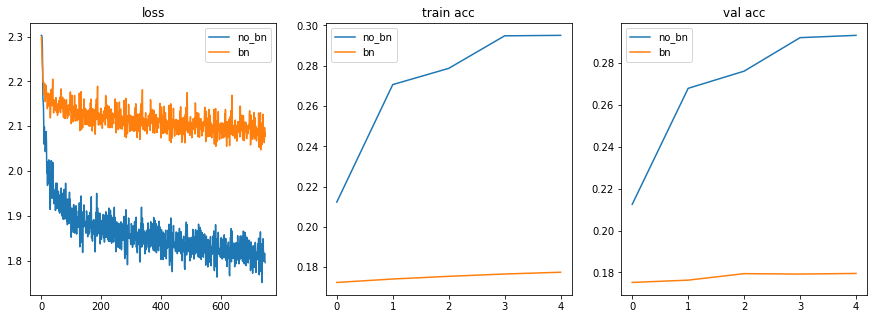

In [27]:
# Plot bn and no_bn results together in three plots and make a comparison. 
title_name = ["loss", "train acc", "val acc"]
_, axarr = plt.subplots(1,3, figsize=(15,5))
for i in range(3):
    axarr[i].plot(hist_deep_no_bn[i], label="no_bn")
    axarr[i].plot(hist_deep_bn[i], label="bn")
    axarr[i].legend(), axarr[i].set_title(title_name[i])
plt.show()

<span style="color:red"><strong>TODO:</strong></span> Describe what you find in this experiment.

Answer: **[In my plot, batch normalization is worse than network without batch normalization. But I think this is because my network is shallow and although I add the num_epoch, batch normalization is still worse. If my network is deep, the network without bn will be overfit, whereas the model with bn is less likely to overfit.]**

## Part 2: Dropout

### Implement dropout_forward function

<span style="color:red"><strong>TODO:</strong></span> Edit function **dropout_forward** in **./utils/reg_funcs.py**. If the code is running correctly, you will see that the outputs of the verification code should be close to each other. 
<br><br> If the function is correct, then **the output mean should be close to the input mean. Input mean and output test mean should be identical.**

In [31]:
x_in = np.random.randn(500, 500) + 10

In [32]:
################################################
# Checking/verification code. Don't change it. #
################################################
from utils.reg_funcs import dropout_forward
from utils.reg_funcs import dropout_backward

p = 0.7
dropout_config = {"enabled": True, "keep_prob": p}
# feedforward
out, cache = dropout_forward(x=x_in, dropout_config=dropout_config, mode="train")
out_test, _ = dropout_forward(x=x_in, dropout_config=dropout_config, mode="test") 
# backward
dout = np.ones_like(x_in)
dx = dropout_backward(dout, cache)
################################################
# Checking/verification code. Don't change it. #
################################################
# Check forward correctness
print("mean_of_input = {}".format(p*np.mean(x_in)))
print("mean_of_out = {}".format(np.mean(out)))
print("mean_of_out_test = {}".format(np.mean(out_test)))

mean_of_input = 7.00016906758361
mean_of_out = 7.015409579472031
mean_of_out_test = 7.000169067583612


### Dropout Experiments with MLP

<span style="color:red"><strong>TODO:</strong></span>

1. Add dropout into the MLP. Review **loss**, **predict** functions of class **MLP** in **./utils/neuralnets/mlp.py** and understand how the dropout is added into the MLP.

2. Customize your own MLP network.Then, train networks with different **keep_prob**, like 0.1, 0.3, 0.5, 0.7, 0.9, 1. If **keep_prob**==1, then the network is the MLP without dropout.

3. Plot the loss, training accuracy, and validation accuracy curves.

Note that checking/validation code is included below with preselected dropout parameters.

In [33]:
# Here is an example on how to collect loss and accuracy info
dropout_config = {"enabled":True, "keep_prob": 1}
model = MLP(input_dim=X_train.shape[1], hidden_dims=[200], num_classes=10, 
            weight_scale=1e-3, l2_reg=0.0, dropout_config=dropout_config)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_no_dropout = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=2, batch_size=100, learning_rate=1e-3, learning_decay=0.95, 
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.845, new learning rate = 0.00095
epoch 2: valid acc = 0.8573, new learning rate = 0.0009025


In [34]:
dropout_config["keep_prob"] = 0.9
model = MLP(input_dim=X_train.shape[1], hidden_dims=[200], num_classes=10, 
            weight_scale=1e-2, l2_reg=0.0, dropout_config=dropout_config)
optimizer = AdamOptim(model)
hist_dropout_9 = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=2, batch_size=100, learning_rate=1e-3, learning_decay=0.95,
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.8451, new learning rate = 0.00095
epoch 2: valid acc = 0.857, new learning rate = 0.0009025


In [35]:
dropout_config["keep_prob"] = 0.7
model = MLP(input_dim=X_train.shape[1], hidden_dims=[200], num_classes=10, 
            weight_scale=1e-2, l2_reg=0.0, dropout_config=dropout_config)
optimizer = AdamOptim(model)
hist_dropout_7 = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=2, batch_size=100, learning_rate=1e-3, learning_decay=0.95,
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.8407, new learning rate = 0.00095
epoch 2: valid acc = 0.8626, new learning rate = 0.0009025


In [36]:
dropout_config["keep_prob"] = 0.5
model = MLP(input_dim=X_train.shape[1], hidden_dims=[200], num_classes=10, 
            weight_scale=1e-2, l2_reg=0.0, dropout_config=dropout_config)
optimizer = AdamOptim(model)
hist_dropout_5 = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=2, batch_size=100, learning_rate=1e-3, learning_decay=0.95,
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.8484, new learning rate = 0.00095
epoch 2: valid acc = 0.8515, new learning rate = 0.0009025


In [37]:
dropout_config["keep_prob"] = 0.3
model = MLP(input_dim=X_train.shape[1], hidden_dims=[200], num_classes=10, 
            weight_scale=1e-2, l2_reg=0.0, dropout_config=dropout_config)
optimizer = AdamOptim(model)
hist_dropout_3 = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=2, batch_size=100, learning_rate=1e-3, learning_decay=0.95,
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.8407, new learning rate = 0.00095
epoch 2: valid acc = 0.8526, new learning rate = 0.0009025


In [38]:
# small retention rate
dropout_config["keep_prob"] = 0.1
model = MLP(input_dim=X_train.shape[1], hidden_dims=[200], num_classes=10, 
            weight_scale=1e-2, l2_reg=0.0, dropout_config=dropout_config)
optimizer = AdamOptim(model)
hist_dropout_1 = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=2, batch_size=100, learning_rate=1e-3, learning_decay=0.95,
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.8131, new learning rate = 0.00095
epoch 2: valid acc = 0.8256, new learning rate = 0.0009025


In [39]:
loss_no_dropout, train_acc_no_dropout, val_acc_no_dropout = hist_no_dropout
loss_dropout_1, train_acc_dropout_1, val_acc_dropout_1 = hist_dropout_1
loss_dropout_3, train_acc_dropout_3, val_acc_dropout_3 = hist_dropout_3
loss_dropout_5, train_acc_dropout_5, val_acc_dropout_5 = hist_dropout_5
loss_dropout_7, train_acc_dropout_7, val_acc_dropout_7 = hist_dropout_7
loss_dropout_9, train_acc_dropout_9, val_acc_dropout_9 = hist_dropout_9

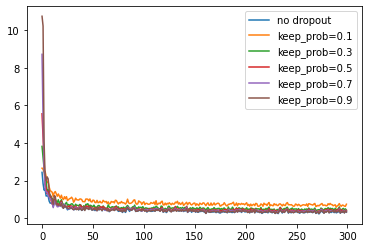

In [40]:
plt.plot(loss_no_dropout, label="no dropout")
plt.plot(loss_dropout_1, label="keep_prob=0.1")
plt.plot(loss_dropout_3, label="keep_prob=0.3")
plt.plot(loss_dropout_5, label="keep_prob=0.5")
plt.plot(loss_dropout_7, label="keep_prob=0.7")
plt.plot(loss_dropout_9, label="keep_prob=0.9")
plt.legend()
plt.show()

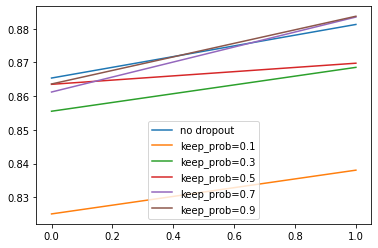

In [41]:
plt.plot(train_acc_no_dropout, label="no dropout")
plt.plot(train_acc_dropout_1, label="keep_prob=0.1")
plt.plot(train_acc_dropout_3, label="keep_prob=0.3")
plt.plot(train_acc_dropout_5, label="keep_prob=0.5")
plt.plot(train_acc_dropout_7, label="keep_prob=0.7")
plt.plot(train_acc_dropout_9, label="keep_prob=0.9")
plt.legend()
plt.show()

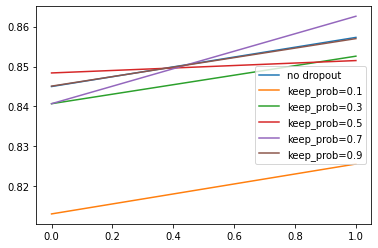

In [42]:
plt.plot(val_acc_no_dropout, label="no dropout")
plt.plot(val_acc_dropout_1, label="keep_prob=0.1")
plt.plot(val_acc_dropout_3, label="keep_prob=0.3")
plt.plot(val_acc_dropout_5, label="keep_prob=0.5")
plt.plot(val_acc_dropout_7, label="keep_prob=0.7")
plt.plot(val_acc_dropout_9, label="keep_prob=0.9")
plt.legend()
plt.show()

<span style="color:red"><strong>TODO:</strong></span> Describe what you find in this dropout experiment.

Answer: **[First, there is not much different in loss. Second, the training accuracy is almost the same with prob bigger than 0.7.But will decrease largely after the prob decrease. Third, different from training accuracy, prob of 0.7 has the best test accuracy. I think this is because dropout could regulate the result and improve the overfitting problem. ]**

## Part 3: Dropout + Batch Normalization

In [43]:
# Create a deep network with both dropout and batch normalization.
dropout_config = {"enabled":True, "keep_prob": 0.7}
use_bn = True
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100, 50], num_classes=10, 
            weight_scale=1e-3, l2_reg=0.0, dropout_config=dropout_config, use_bn=use_bn)
optimizer = AdamOptim(model)

# hist_no_dropout contains loss, train acc and valid acc history.
hist_deep_bn = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=5, batch_size=200, learning_rate=1e-3, learning_decay=1.0, 
                           verbose=False, record_interval = 4)

number of batches for training: 300
epoch 1: valid acc = 0.2067, new learning rate = 0.001
epoch 2: valid acc = 0.2229, new learning rate = 0.001
epoch 3: valid acc = 0.3385, new learning rate = 0.001
epoch 4: valid acc = 0.4166, new learning rate = 0.001
epoch 5: valid acc = 0.4649, new learning rate = 0.001


## Reference
* Weight Normalization: A Simple Reparameterization to Accelerate Training of Deep Neural Networks https://arxiv.org/abs/1602.07868
* Highway netowrk https://arxiv.org/pdf/1505.00387.pdf